# Scope
To train frequency nadir and VSG power peak with generated data

```
Note: 
1）add negtive part to the original data and shuffle; *** To be solved: add dPe as input? ***
2）remember to normalize and denormalize input/output while using the neural network.
```


## Load data and normalization

In [69]:
import torch
import pandas as pd
import numpy as np
import copy
from torch import nn
from d2l import torch as d2l
import matplotlib
import matplotlib.pyplot as plt

In [70]:
# load data
data_fnadir = pd.read_csv('fnadir.txt', dtype=float, header=None).values
data_Ppeak = pd.read_csv('Ppeak.txt', dtype=float, header=None).values
print(f'Data dimention: {data_fnadir.shape}')

# Normalization
fnadir_mean = np.mean(data_fnadir, axis=0)
fnadir_std = np.std(data_fnadir, axis=0)
fnadir_norm = (data_fnadir - fnadir_mean)/fnadir_std

Ppeak_mean = np.mean(data_Ppeak, axis=0)
Ppeak_std = np.std(data_Ppeak, axis=0)
Ppeak_norm = (data_Ppeak - Ppeak_mean)/Ppeak_std

Data dimention: (1000, 5)


In [71]:
# add negative part
fnadir_norm = np.concatenate((fnadir_norm, -fnadir_norm), axis=0)
Ppeak_norm = np.concatenate((Ppeak_norm, -Ppeak_norm), axis=0)

# fnadir_norm.shape

## Construct neural network


In [72]:
# ini MLP neural network
net_fnadir = nn.Sequential(nn.Linear(4, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

net_Ppeak = nn.Sequential(nn.Linear(6, 64),
                          nn.ReLU(),
                          nn.Linear(64, 1))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_fnadir.apply(init_weights)
net_Ppeak.apply(init_weights)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [73]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Use Adam optimizer
    optimizer = torch.optim.SGD(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features),train_labels).item())
        if test_labels is not None:
            test_ls.append(loss(net(test_features),test_labels).item())
    return train_ls, test_ls

In [74]:
# shuffle training data
np.random.shuffle(fnadir_norm)
np.random.shuffle(Ppeak_norm)

### Train fnadir network 

In [75]:
# Split as training and test data
split_num = int(0.95 * fnadir_norm.shape[0]) # 0.95 means 95% as training data
print(f'95% as training data, 5% as test data')

train_data, test_data = fnadir_norm[0:split_num, ...].copy(), fnadir_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:4]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:4]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

95% as training data, 5% as test data
Training data dimention: (1900, 5)
Test data dimention: (99, 5)


In [76]:
# train_feature

In [77]:
# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

In [78]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 64, 0.05, 250, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_fnadir, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

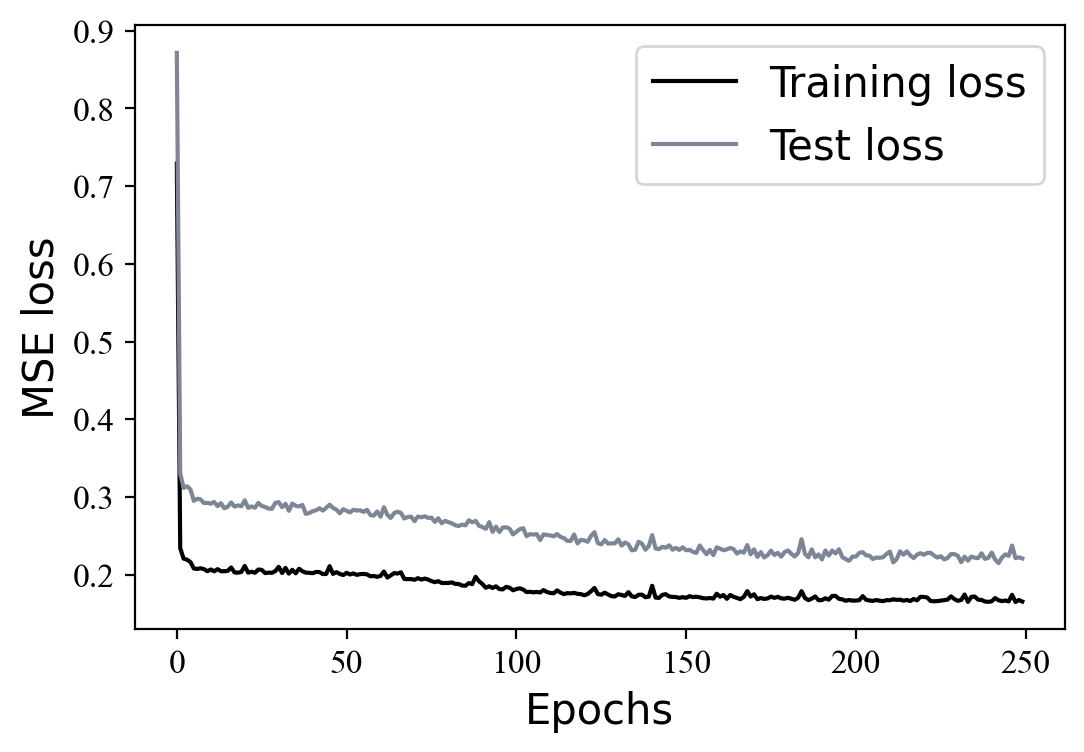

In [79]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [80]:
# Export neural network model
model_scripted = torch.jit.script(net_fnadir) # Export to TorchScript
model_scripted.save('net_fnadir.pt') # Save

### Train Ppeak network

In [81]:
train_data, test_data = Ppeak_norm[0:split_num, ...].copy(), Ppeak_norm[split_num:-1, ...].copy()
print(f'Training data dimention: {train_data.shape}')
print(f'Test data dimention: {test_data.shape}')

train_feature = train_data[:, 0:6]
train_label = train_data[:, -1]
train_label = np.expand_dims(train_label, axis=1)

test_feature = test_data[:, 0:6]
test_label = test_data[:, -1]
test_label = np.expand_dims(test_label, axis=1)

# convert np array to torch tensor
train_feature = torch.tensor(train_feature, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.float32)
test_feature = torch.tensor(test_feature, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.float32)

Training data dimention: (1900, 7)
Test data dimention: (99, 7)


In [82]:
# training hyperparameter
batch_size, lr, num_epochs, weight_decay = 64, 0.05, 250, 0
loss = nn.MSELoss()

# train
training_ls, validation_ls = train(net_Ppeak, train_feature, train_label, test_feature, test_label, \
    num_epochs, lr, weight_decay, batch_size)

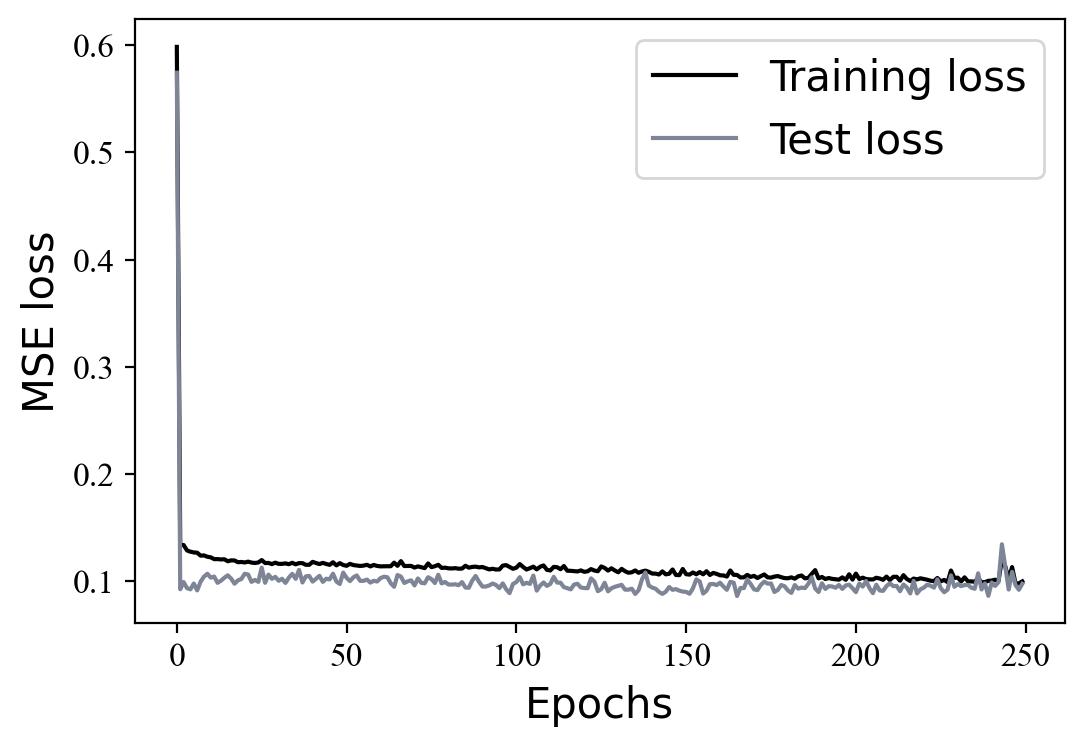

In [83]:
# plot training loss
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.xticks(fontproperties = 'Times New Roman', fontsize=12)
plt.yticks(fontproperties = 'Times New Roman', fontsize=12)
plt.grid(color='white')

figP = ax.plot(training_ls, label='training loss', linewidth=1.5, c='black')
figQ = ax.plot(validation_ls, label='test loss', linewidth=1.5, c='#7d8597')
# ax.set_ylim([-0.02, 0.55])
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('MSE loss', color = 'black', fontsize=15)
ax.tick_params(axis='y', labelcolor='black')
ax.legend(['Training loss', 'Test loss'], fontsize=15)

In [84]:
# Export neural network model
model_scripted = torch.jit.script(net_Ppeak) # Export to TorchScript
model_scripted.save('net_Ppeak.pt') # Save

## Export data used in optimization

In [85]:
fnorm = np.array([fnadir_mean, fnadir_std])
fnorm

array([[ 1.98956780e+01,  1.21974091e+01,  8.01385090e+01,
         1.26078088e+02, -1.26373799e-02],
       [ 5.74459958e+00,  4.34458266e+00,  3.99024588e+01,
         4.30255486e+01,  5.49252831e-03]])

In [86]:
pnorm = np.array([Ppeak_mean, Ppeak_std])
pnorm

array([[1.98956780e+01, 1.21974091e+01, 8.01385090e+01, 1.26078088e+02,
        9.81245345e-01, 2.53360180e+00, 6.72772306e-02],
       [5.74459958e+00, 4.34458266e+00, 3.99024588e+01, 4.30255486e+01,
        5.87552164e-01, 8.67663609e-01, 3.64055272e-02]])

In [90]:
# data norm
pd.DataFrame(fnorm).to_csv("fnorm.csv", header=['M','D','Fg','Rg','fnadir'], index=False)
pd.DataFrame(pnorm).to_csv("pnorm.csv", header=['M','D','Fg','Rg','Mvsg','Dvsg','Ppeak'], index=False)

In [91]:
# net_fnadir and net_Ppeak
Layer = []
for layer in net_fnadir.children():
    Layer.append(layer)

In [92]:
Layer

[Linear(in_features=4, out_features=64, bias=True),
 ReLU(),
 Linear(in_features=64, out_features=1, bias=True)]

In [101]:
Layer[0].state_dict()['weight'].detach().numpy()

array([[ 5.33160642e-02, -1.89501289e-02,  1.03133187e-01,
         5.19209914e-03],
       [ 9.08986628e-02, -2.18824912e-02, -5.21098673e-02,
        -6.64912388e-02],
       [-5.45518436e-02,  8.15014914e-02,  1.33792698e-01,
         7.36207962e-02],
       [ 1.36136664e-02,  7.08199758e-03,  4.71732952e-03,
        -8.13760143e-03],
       [ 1.77236330e-02, -7.47407647e-03,  9.46632680e-03,
        -7.02234451e-03],
       [ 8.42982456e-02, -3.39391641e-02,  1.31388366e-01,
         2.76079271e-02],
       [-7.10842311e-02,  3.07966750e-02, -9.22438800e-02,
        -3.10047064e-02],
       [-5.87871745e-02,  1.69993900e-02, -8.28713849e-02,
        -8.29573441e-03],
       [-5.52397966e-03,  1.83746591e-02, -1.19476570e-02,
         8.11094604e-03],
       [-8.16288516e-02,  3.53212655e-02, -1.03631489e-01,
        -3.66353765e-02],
       [-7.29141384e-02,  2.62863506e-02, -7.12454915e-02,
        -8.29415675e-03],
       [-9.14650187e-02,  7.21760318e-02, -1.45368874e-01,
      